In [2]:
from landlab import imshow_grid, RasterModelGrid
from src import icyrivermodel
import matplotlib.pyplot as plt
import numpy as np

# Icy River Model

Josie Arcuri

final assignment for intro to numerical modeling, CU Boulder Geological Sciences

4/27/2022

    Rivers running through permafrost look and move material differently than warm alluvial channels.  These rivers are seasonally frozen and their banks contain significant proportions of ice - both in soil pore space and in massive ice wedges.  patterns arising from the thermal erosion - or mobilization of riverbank material during melting - could possibly explain icy river morphology and erosion patterns. I use landlab to model the linear heat diffusion through an idealized riverbank, and track permafrost heat at the interface of permafrost and river water (termed a bankline). Temperature gradients across the bankline interface are used to horizontally move subaqueoes portion of thbankline left each timestep. nodes in the landlab grid are re-assigned to boundaries once they are supased by the bankline. additionally, the bankline face above water level is eroded with a zero-degree-day empirical erosion law.  In case subaqueous erosion is greater than subaerial, we add a simple slumping rule where overhang is sheared-off when a critical bankline angle is acheived.  Thermal erosion, in conjunction with subaerial melting and slumping, produce the general shape of icy riverbanks observed in the arctic. 

## Picture

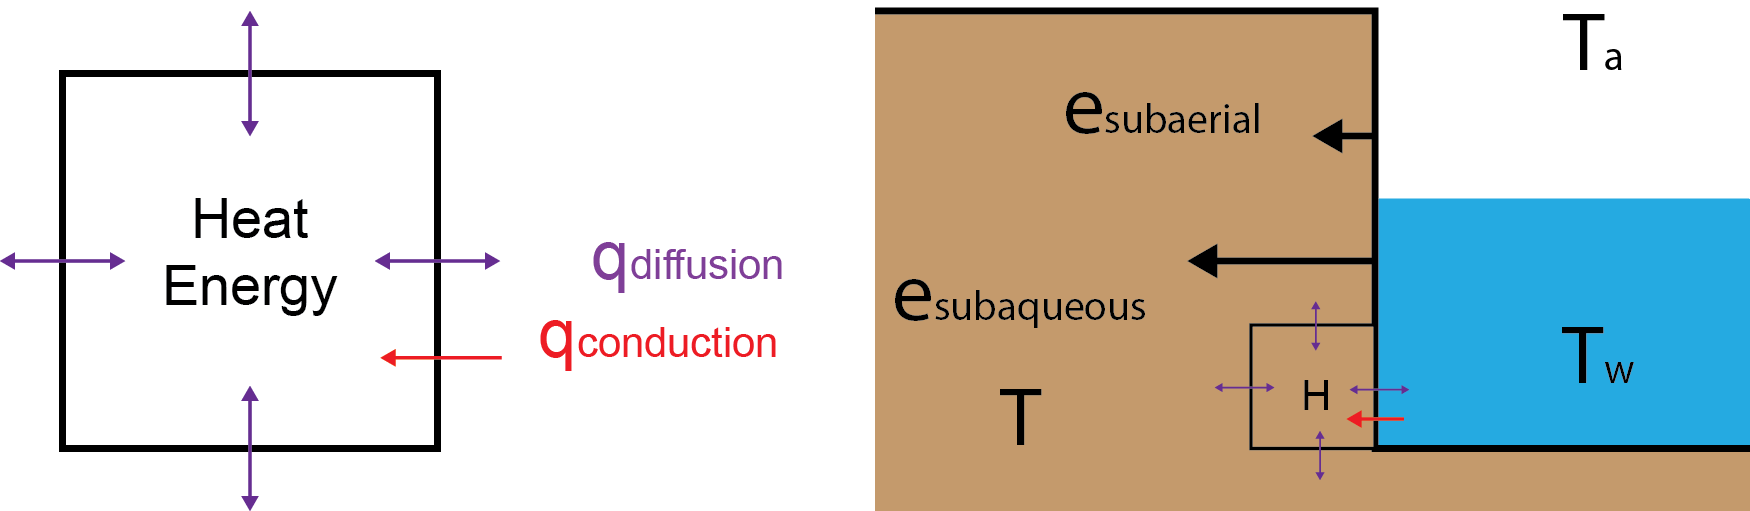

## Define Physical Processes and Boundaries

$k_{perma}$  = thermal conductivity of permafrost = 1 $\frac{W}{m K^{\circ}}$
dependent 

$T_w$ = temperature of river water $K^{\circ}$

$T_a$ = temperature of air $K^{\circ}$

$T_p$ = temperature of permafrost $K^{\circ}$

## subaerial erosion

# $\dfrac{\delta dx}{\delta t} = -\alpha [T_{air} - T_{melt}]$

## subaqueous erosion


$q_{diff}$ = diffusion of heat throughout riverbank

$q_{diff} = -k\dfrac{\delta q}{\delta x}$

$q_{conduction}$ = heat supplied by river water to permafrost

$q_{conduction} = -k_{perma} \Delta T = - k_{perma} (T_{water} - T_{melt})$


## slumping
Under Construction


In [2]:
params = {
    "run_duration": 365 * 11,  # days
    "dt": .05,  # days
    "lower_bound__temperature": 273.15-10,  # degrees C
    "lower_bound__depth": -15,  # m below river bed
    "air_temperature__mean": 270,  # degrees C
    "air_temperature__amplitude": 20,  # degrees C
    "air_temperature__period": 365,  # days
    "water_temperature__max": 288.15,  # degrees C
    "bank_width": 15,  # m
    "bank_height": 3,  # m
    "dx": 0.2,  # m
    "initial_river_stage": 1,  # m
    "river_half_width": 5,  # m
    "riverbed_temp": 273.15,  # degrees K
    "bankline_dx": .1,# m
    "subaerial_erosion": 0.001,#m
    "morph_factor": 10,#[*],
    "save_dt": 150
}

## Assumptions

$dz, dy, L_{ice}, \rho_{ice}, W, c_p, \rho_{perma}, T_{melt} \neq f(t)$

all material eroded from thre riverbank is immediately transported downstream


## Energy Balance

$$\dfrac{\delta E_{heat}}{\delta t} = q_{conduction} dy dz$$

$E_{heat} = L_i \rho_{ice} W_{ice}  dx dy dz  + c_{perma} \rho_{perma} dx dy dz [ T_{melt} - T] $

$\dfrac{\delta L_i \rho_{ice} W_{ice}  dx dy dz}{\delta t}+ (\dfrac{\delta c_{p} \rho_{perma}dx dy dz [T_{melt}- T]}{\delta t})= - k_{perma} (T_{water} - T_{melt}) dy dz$

$L_i \rho_{ice} W_{ice}  \dfrac{\delta dx }{\delta t}+ c_{p} \rho_{perma}(\dfrac{\delta dx [T_{melt}- T]}{\delta t}) = - k_{perma} (T_{water} - T_{melt})$

$L_i \rho_{ice} W_{ice}  \dfrac{\delta dx }{\delta t}+ c_{p} \rho_{perma}(dx \dfrac{\delta [T_{melt}- T]}{\delta t}+[T_{melt}- T]\dfrac{\delta dx }{\delta t}) = - k_{perma} (T_{water} - T_{melt})$

$\dfrac{\delta dx }{\delta t} = \dfrac{- k_{perma} (T_{water} - T_{melt}) + c_{perma} \rho_{perma} (\dfrac{\delta T}{\delta t}) dx}{L_i \rho_{ice} W_{ice} + c_{p} \rho_{perma}[T_{melt}- T]}$


$\dfrac{\delta T }{\delta t}dx dy dz\rho_{perma} c_{perma}=q_{diff}|_{x+dx} dy dz - q_{diff}|_{x}dy dz$

$\dfrac{\delta T }{\delta t}=- \dfrac{k_{perma}}{\rho_{perma} c_{p}}\dfrac{\delta^2 T}{\delta x^2} $

# $$\dfrac{\delta dx }{\delta t}=- \dfrac{k_{perma}([T_{water} - T_{melt}] +dx \dfrac{\delta^2 T}{\delta x^2})}{L_i \rho_{ice} W_{ice} + c_{p} \rho_{perma}[T_{melt}- T]}  $$


## Boundary Conditions
#### permafrost boundaries
$T_p(x, z = - 15 m)$ = -5 $C^{\circ}$

$T_p(x = 0, z<=$bank_height$)$ = -5 $C^{\circ}$

$T_p(x =$ bank_width+river_half_width$, z<=$riverbed_z$) = $-5 $C^{\circ}$

#### subaerial boundaries
$T_a(t) = MAT + \frac{Amp}{2} -\cos(\frac{2 \pi t}{365})$

#### subaqueous boundaries
$$DOY = t \mod 365$$

$$T_w(DOY) =   \left\{
\begin{array}{ll}
      (T_a(DOY)+ T_{melt})/2 & DOY < t_{rib} \\
      T_{melt}+ (T_{wmax} - T_{melt})\frac{ DOY - t_{rib}}{t_{highflow} - t_{rib}} & t_{rib}<=  DOY < t_{highflow}  \\
       T_{melt}+ (T_{wmax} - T_{melt})\frac{ DOY - t_{freeze}}{t_{freeze} - t_{highflow}} & t_{highflow}<=  DOY <= t_{freeze} \\
      (T_a(DOY)+ T_{melt})/2 & DOY > t_{freeze} \\
\end{array} 
\right.  $$

#### riverbed boundaries
$$T_{rb}(DOY) =   \left\{
\begin{array}{ll}
      T_w(DOY) & DOY < t_{rib} \\
      T_{melt} & t_{rib}<=DOY<=t_{freeze}\\
      T_w(DOY) & DOY > t_{freeze} \\
\end{array} 
\right.  $$

## Initial Conditions

$T_p(x, z)$ = -5 $C^{\circ}$


In [3]:
icyriver = icyrivermodel.IcyRiver(params)
icyriver.plot_riverbank_temp()#show = True)

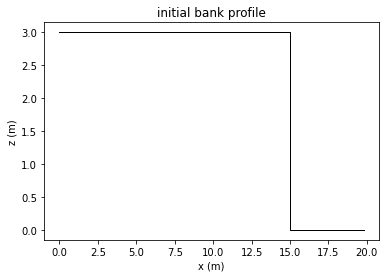

In [4]:
plt.plot(icyriver.banklines[-1].x, icyriver.banklines[-1].z, c = 'k',linewidth = 1, alpha = 1)
plt.title("initial bank profile")
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.show()

## Solution Scheme for  $X(z, t)$ : bankline position through time


$\Delta X  = -  \dfrac{k_{perma}([T_{water} - T_{melt}] + dx \dfrac{T_{div}(z,t)}{dx^2})}{L_i \rho_{ice} W_{ice} + c_{p} \rho_{perma}[T_{melt}- T]}$

# $ X(z,t) = X(z, t-dt) + \frac{\delta dx}{\delta t} dt$

## Demonstration

In [5]:
icyriver.run()

C:\Users\Josie\Desktop\icyrivermodel\src\icyrivermodel.py:416: RuntimeWarning: divide by zero encountered in true_divide
  dzdx = np.concatenate((np.diff(z) / np.diff(x), [0]))
C:\Users\Josie\Desktop\icyrivermodel\src\icyrivermodel.py:416: RuntimeWarning: invalid value encountered in true_divide
  dzdx = np.concatenate((np.diff(z) / np.diff(x), [0]))
C:\Users\Josie\Desktop\icyrivermodel\src\icyrivermodel.py:462: RuntimeWarning: invalid value encountered in double_scalars
  overhang = (z[top] - z[hinge]) / (x[top] - x[hinge])


slump! at DOY: 134
slump! at DOY: 149
slump! at DOY: 154
slump! at DOY: 155


In [6]:
#icyriver.animate_riverbank_profile(dt= int(params["save_dt"]/icyriver.dt))

In [7]:
icyriver.time/365

11.000000000016001

In [8]:
#icyrivermodel.make_animation('temp_movie/', 'new_riverbanktemp')
#print(len(icyriver.banklines[-1].x))

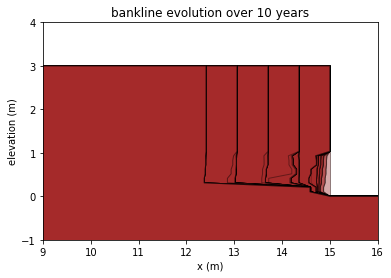

In [9]:
#[plt.plot(bl.x, bl.z, c = 'k',linewidth = .5, alpha = .25) for bl in icyriver.banklines[::61]]
[plt.fill_between(x=bl.x,y1=bl.z,y2=np.ones_like(bl.z) * -2,color="brown",edgecolor = 'k', alpha =.5*(bl.age/icyriver.time))for bl in icyriver.banklines[::int(31/icyriver.dt)]]
#scs = [plt.scatter(bl.x,bl.z, c = bl.T, cmap = 'hot') for bl in [icyriver.banklines[-1]]]
#plt.colorbar(scs[-1], label = "surface temperature \n [$\degree$ C]")http://localhost:8888/notebooks/Icyrivermodel_demo.ipynb#
plt.title("bankline evolution over "+ str(int(icyriver.time/365) - 1 )+" years")
plt.xlabel("x (m)")
#plt.gca().axis('equal')
plt.xlim((9, 16))
plt.ylim((-1, 4))
plt.ylabel("elevation (m)")
plt.savefig("10yearsbankevolution.png", dpi = 500)

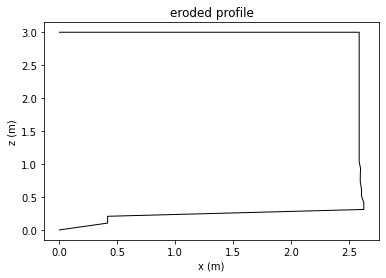

In [10]:
plt.plot(icyriver.banklines[0].x -icyriver.banklines[-1].x , icyriver.banklines[0].z, c = 'k',linewidth = 1, alpha = 1)
#plt.plot(icyriver.banklines[-1].x, icyriver.banklines[-1].z, c = 'k',linewidth = 1, alpha = 1)
plt.title("eroded profile")
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.show()

In [11]:
import numpy as np
print("volume eroded = " + str(np.sum(icyriver.banklines[0].x - icyriver.banklines[-1].x) *params['bankline_dx'])+ " m^3")

volume eroded = 10.5435488759 m^3


## References

- Barnhart, K.R., Anderson, R.S., Overeem, I., Wobus, C., Clow, G.D., and Urban, F.E., 2014, Modeling erosion of ice-rich permafrost bluffs along the Alaskan Beaufort Sea coast: Journal of Geophysical Research: Earth Surface, v. 119, p. 1155–1179, doi:10.1002/2013JF002845.
- Churchill, S.W., and Chu, H.H.S., 1975, Correlating equations for laminar and turbulent free convection from a vertical plate: International Journal of Heat and Mass Transfer, v. 18, p. 1323–1329, doi:10.1016/0017-9310(75)90243-4.
- Karlstrom, L., Gajjar, P., and Manga, M., 2013, Meander formation in supraglacial streams: Journal of Geophysical Research: Earth Surface, v. 118, p. 1897–1907, doi:10.1002/jgrf.20135.
- Karlstrom, L., and Yang, K., 2016, Fluvial supraglacial landscape evolution on the Greenland Ice Sheet: Geophysical Research Letters, v. 43, p. 2683–2692, doi:10.1002/2016GL067697.
- Kobayashi, N., 1985, Formation of thermoerosional niches into frozen bluffs due to storm surges on the Beaufort Sea coast: Journal of Geophysical Research: Oceans, v. 90, p. 11983–11988, doi:10.1029/JC090iC06p11983.
- Kobayashi, N., and Aktan, D., 1986, Thermoerosion of Frozen Sediment Under Wave Action: Journal of Waterway, Port, Coastal, and Ocean Engineering, v. 112, p. 140–158, doi:10.1061/(ASCE)0733-950X(1986)112:1(140).
- Kobayashi, N., Vidrine, J.C., Nairn, R.B., and Soloman, S.M., 1999, Erosion of Frozen Cliffs Due to Storm Surge on Beaufort Sea Coast: Journal of Coastal Research, v. 15, p. 332–344, https://www.jstor.org/stable/4298946 (accessed April 2022).
- Shur, Y., Jones, B.M., Kanevskiy, M., Jorgenson, T., Jones, M.K.W., Fortier, D., Stephani, E., and Vasiliev, A., 2021, Fluvio-thermal erosion and thermal denudation in the yedoma region of northern Alaska: Revisiting the Itkillik River exposure: Permafrost and Periglacial Processes, v. 32, p. 277–298, doi:10.1002/ppp.2105.
- Stephani, E., Jones, B., and Kanevskiy, M., 2019, Assessing Riverbank Erosion and Land Cover Changes in Permafrost Regions Based on a Terrain Analysis Approach: An Example from the Colville River Delta, Northern Alaska: , p. 678–686, doi:10.1061/9780784482599.078.


def get_river_temperature(t, air_temp, trib = 130, tfreeze = 310, thigh = 176, tmax = 288.15):

    melttemp = 273.15
    trib_airtemp = np.mean((get_air_temperature(trib), melttemp))
    tfreeze_airtemp = np.mean((get_air_temperature(tfreeze), melttemp))
    
    if (t % 365) >= trib and (t % 365) <= thigh:
        river_temp = trib_airtemp +  (tmax  - trib_airtemp) * ((int(t % 365)-trib) / (thigh - trib))
        bed_temp = melttemp
    elif (t % 365) > thigh and (t % 365) <= tfreeze:
        river_temp = tfreeze_airtemp + (tmax - tfreeze_airtemp) * ((tfreeze - int(t % 365))/ ((tfreeze - thigh)))
        bed_temp = melttemp
    else:
        river_temp = (air_temp+ melttemp)/2
        bed_temp = river_temp
    return river_temp, bed_temp

def get_air_temperature(t, mean = 273.15 - 3, amplitude = 20, period = 365):
   
    air_temp = mean - (amplitude / 2) * np.cos(np.pi * 2 * t / (period))
    return air_temp

air_temp = np.zeros(365)
river_temp = np.zeros(365)
bed_temp = np.zeros(365)
for i in range(365):
    air_temp[i] = get_air_temperature(i)
    res = get_river_temperature(i, air_temp[i])
    river_temp[i] = res[0]
    bed_temp[i] = res[1]

    
#plt.xlim((130, 175))
plt.plot(range(365), river_temp-273.15, color = 'blue', label = "river")
plt.plot(range(365), bed_temp-273.15, color='grey', linestyle = '--', label = "riverbed")
plt.plot(range(365), air_temp-273.15, color = 'green', label = "air")
plt.legend()
plt.xlabel("DOY")
plt.ylabel('Temperature ($\circ C$)')
plt.savefig('boundaries.png', dpi=1000)


In [12]:
get_river_temperature(30, 260)

NameError: name 'get_river_temperature' is not defined